## Data preparation and design of Hybrid Timeseries models and variants
This notebook presents the process of preparing input data and implementing a hybrid model architecture to capture spatial-temporal patterns in apparent temperature.

### Main idea:
The model is designed for a time series forecasting task

Input: Preprocessed apparent temperature data with two features: mean apparent temperature and max apparent temperature, collected from all stations.

Output: 2 target features such as mean apparent temperature, max apparent temperature.


In [1]:
import typing
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from math import radians, sin, cos, sqrt, atan2
import time


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import keras
from keras import layers, ops

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

2025-07-11 13:19:42.871432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752239983.070141      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752239983.125879      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df_CaMau = pd.read_csv('/kaggle/input/at-vietnam-data/Data_AT_FilteredDate/CaMau_FilteredDate.csv')
df_LangSon = pd.read_csv('/kaggle/input/at-vietnam-data/Data_AT_FilteredDate/LangSon_FilteredDate.csv')
df_LaoCai = pd.read_csv('/kaggle/input/at-vietnam-data/Data_AT_FilteredDate/LaoCai_FilteredDate.csv')
df_NoiBai = pd.read_csv('/kaggle/input/at-vietnam-data/Data_AT_FilteredDate/NoiBai_FilteredDate.csv')
df_PhuBai = pd.read_csv('/kaggle/input/at-vietnam-data/Data_AT_FilteredDate/PhuBai_FilteredDate.csv')
df_QuyNhon = pd.read_csv('/kaggle/input/at-vietnam-data/Data_AT_FilteredDate/QuyNhon_FilteredDate.csv')
df_TPHCM = pd.read_csv('/kaggle/input/at-vietnam-data/Data_AT_FilteredDate/TPHCM_FilteredDate.csv')
df_Vinh = pd.read_csv('/kaggle/input/at-vietnam-data/Data_AT_FilteredDate/Vinh_FilteredDate.csv')

station_df = {
    'Noi Bai': df_NoiBai,
    'Lang Son': df_LangSon,
    'Lao Cai': df_LaoCai,

    'Vinh': df_Vinh,
    'Phu Bai': df_PhuBai,
    'Quy Nhon': df_QuyNhon,

    'TPHCM': df_TPHCM,
    'Ca Mau': df_CaMau
}
df_lat = pd.DataFrame({
    'lat_NoiBai': station_df['Noi Bai']['LATITUDE'],
    'lat_LangSon': station_df['Lang Son']['LATITUDE'],
    'lat_LaoCai': station_df['Lao Cai']['LATITUDE'],
    'lat_Vinh': station_df['Vinh']['LATITUDE'],
    'lat_PhuBai': station_df['Phu Bai']['LATITUDE'],
    'lat_QuyNhon': station_df['Quy Nhon']['LATITUDE'],
    'lat_TPHCM': station_df['TPHCM']['LATITUDE'],
    'lat_CaMau': station_df['Ca Mau']['LATITUDE'],
})

df_lon = pd.DataFrame({
    'lon_NoiBai': station_df['Noi Bai']['LONGITUDE'],
    'lon_LangSon': station_df['Lang Son']['LONGITUDE'],
    'lon_LaoCai': station_df['Lao Cai']['LONGITUDE'],
    'lon_Vinh': station_df['Vinh']['LONGITUDE'],
    'lon_PhuBai': station_df['Phu Bai']['LONGITUDE'],
    'lon_QuyNhon': station_df['Quy Nhon']['LONGITUDE'],
    'lon_TPHCM': station_df['TPHCM']['LONGITUDE'],
    'lon_CaMau': station_df['Ca Mau']['LONGITUDE'],
})

df_AT_mean = pd.DataFrame({
    'AT_mean_NoiBai': station_df['Noi Bai']['AT mean'],
    'AT_mean_LangSon': station_df['Lang Son']['AT mean'],
    'AT_mean_LaoCai': station_df['Lao Cai']['AT mean'],
    'AT_mean_Vinh': station_df['Vinh']['AT mean'],
    'AT_mean_PhuBai': station_df['Phu Bai']['AT mean'],
    'AT_mean_QuyNhon': station_df['Quy Nhon']['AT mean'],
    'AT_mean_TPHCM': station_df['TPHCM']['AT mean'],
    'AT_mean_CaMau': station_df['Ca Mau']['AT mean'],
})


df_AT_max = pd.DataFrame({
    'AT_max_NoiBai': station_df['Noi Bai']['AT max'],
    'AT_max_LangSon': station_df['Lang Son']['AT max'],
    'AT_max_LaoCai': station_df['Lao Cai']['AT max'],
    'AT_max_Vinh': station_df['Vinh']['AT max'],
    'AT_max_PhuBai': station_df['Phu Bai']['AT max'],
    'AT_max_QuyNhon': station_df['Quy Nhon']['AT max'],
    'AT_max_TPHCM': station_df['TPHCM']['AT max'],
    'AT_max_CaMau': station_df['Ca Mau']['AT max'],
})

df_TMP2 = pd.DataFrame({
    'TMP2_NoiBai': station_df['Noi Bai']['TMP_2'],
    'TMP2_LangSon': station_df['Lang Son']['TMP_2'],
    'TMP2_LaoCai': station_df['Lao Cai']['TMP_2'],
    'TMP2_Vinh': station_df['Vinh']['TMP_2'],
    'TMP2_PhuBai': station_df['Phu Bai']['TMP_2'],
    'TMP2_QuyNhon': station_df['Quy Nhon']['TMP_2'],
    'TMP2_TPHCM': station_df['TPHCM']['TMP_2'],
    'TMP2_CaMau': station_df['Ca Mau']['TMP_2'],
})

df_RH = pd.DataFrame({
    'RH_NoiBai': station_df['Noi Bai']['RH'],
    'RH_LangSon': station_df['Lang Son']['RH'],
    'RH_LaoCai': station_df['Lao Cai']['RH'],
    'RH_Vinh': station_df['Vinh']['RH'],
    'RH_PhuBai': station_df['Phu Bai']['RH'],
    'RH_QuyNhon': station_df['Quy Nhon']['RH'],
    'RH_TPHCM': station_df['TPHCM']['RH'],
    'RH_CaMau': station_df['Ca Mau']['RH'],
})

df_DEW2 = pd.DataFrame({
    'DEW2_NoiBai': station_df['Noi Bai']['DEW_2'],
    'DEW2_LangSon': station_df['Lang Son']['DEW_2'],
    'DEW2_LaoCai': station_df['Lao Cai']['DEW_2'],
    'DEW2_Vinh': station_df['Vinh']['DEW_2'],
    'DEW2_PhuBai': station_df['Phu Bai']['DEW_2'],
    'DEW2_QuyNhon': station_df['Quy Nhon']['DEW_2'],
    'DEW2_TPHCM': station_df['TPHCM']['DEW_2'],
    'DEW2_CaMau': station_df['Ca Mau']['DEW_2'],
})

### Data preparation

Data preparation steps:
1. **Choose target feature:** The model is configured to forecast either AT mean or AT max, but not both at the same time. Function: choose_target_features
   
2. **Normalize data to range [0, 1] with MinMaxScaler**

   
3. **Divide X and y into three sets (training, validation, and testing)**: Based on the 80 - 10 - 10 ratio, 80% of the data is used for training, 10% for validation, and 10% for testing. Function: split_train_val_test_set

   
4. **Generate sliding windows for time series modeling**: Function create_tf_dataset


In [3]:
# Tách đặc trưng (Chỉ lấy 1 trong 2 đặc trưng AT mean hoặc AT max)
def choose_target_features(station_df, target_features):
    new_station_df = dict()

    for station, df in station_df.items():
        new_df = df.copy()
        new_df = new_df[target_features]
        new_station_df[station] = new_df

    return new_station_df

target_features = ['TMP_2', 'DEW_2', 'RH', 'LATITUDE', 'LONGITUDE', 'AT mean', 'AT max']
station_df = choose_target_features(station_df, target_features)

In [4]:
# Chuẩn hóa dữ liệu bằng MinMaxScaler về khoảng giá trị [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(df_AT_max) #Đổi tham số này
scaled_df = pd.DataFrame(scaled_data, columns=df_AT_max.columns, index=df_AT_max.index)

print(scaled_df)

       AT_max_NoiBai  AT_max_LangSon  AT_max_LaoCai  AT_max_Vinh  \
0          -0.151311        0.033943      -0.018471    -0.309368   
1          -0.036512       -0.052544      -0.042059    -0.152448   
2          -0.090822       -0.151022      -0.122148    -0.140288   
3          -0.060762       -0.151022      -0.096320    -0.064108   
4           0.060307        0.105125       0.213814     0.094422   
...              ...             ...            ...          ...   
11756       0.640389        0.638848       0.610229     0.591739   
11757       0.700324        0.694551       0.710139     0.707887   
11758       0.641312        0.508225       0.758122     0.749196   
11759       0.460584        0.539264       0.406283     0.535589   
11760       0.639467        0.545388       0.545655     0.429187   

       AT_max_PhuBai  AT_max_QuyNhon  AT_max_TPHCM  AT_max_CaMau  
0          -0.122135       -0.042108      0.616857      0.371329  
1          -0.266343       -0.034892      0.40198

In [5]:
#Tách tập dữ liệu theo tỷ lệ 80 - 10 - 10
train_size = 0.8
val_size = 0.1

data_array = np.array(scaled_df) # Chuyển df sang array

num_timestamp = len(data_array)

num_train, num_val = (
        int(num_timestamp * train_size),
        int(num_timestamp * val_size)
)

train_set = data_array[:num_train]
val_set = data_array[num_train: (num_train + num_val)]
test_set = data_array[(num_train + num_val):]

print('Train set: ', train_set.shape)
print('Val set: ', val_set.shape)
print('Test set: ', test_set.shape)

Train set:  (9408, 8)
Val set:  (1176, 8)
Test set:  (1177, 8)


In [6]:
# Tạo cửa sổ dữ liệu
batch_size = 16
input_sequence_length = 31
forecast_horizon = 1
multi_horizon = False

def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
   
    inputs = keras.utils.timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = keras.utils.timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_set, val_set]
)

test_dataset = create_tf_dataset(
    test_set,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_set.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)


print(train_dataset)
print(val_dataset)
print(test_dataset)

I0000 00:00:1752239995.301771      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752239995.302490      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


<CacheDataset element_spec=(TensorSpec(shape=(None, None, 8, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 8), dtype=tf.float64, name=None))>
<CacheDataset element_spec=(TensorSpec(shape=(None, None, 8, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 8), dtype=tf.float64, name=None))>
<CacheDataset element_spec=(TensorSpec(shape=(None, None, 8, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 8), dtype=tf.float64, name=None))>


### Building hybrid model
The hybrid model, proposed in this notebook, combining custom-designed GCN, LSTM-based structures, and multi-head attention.

**Layers in hybrid model**: custom-designed GCN ->  LSTM-based structures -> multi-head attention

In [7]:
threshold=0.5

n_stations = data_array.shape[1]
corr_matrix = np.zeros((n_stations, n_stations))

for i in range(n_stations):
    for j in range(n_stations):
        corr, _ = pearsonr(data_array[:, i], data_array[:, j])
        corr_matrix[i, j] = corr
        
adjacency_matrix = (np.abs(corr_matrix) >= threshold).astype(int)
np.fill_diagonal(adjacency_matrix, 0)

print(adjacency_matrix)

[[0 1 1 1 1 1 0 0]
 [1 0 1 1 1 1 0 0]
 [1 1 0 1 1 1 0 0]
 [1 1 1 0 1 1 0 0]
 [1 1 1 1 0 1 0 0]
 [1 1 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0]]


In [8]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

stations = ['NoiBai', 'LangSon', 'LaoCai', 'Vinh', 'PhuBai', 'QuyNhon', 'TPHCM', 'CaMau']
latitudes = []
longitudes = []

for station in stations:
    latitudes.append(df_lat[f'lat_{station}'].iloc[0])
    longitudes.append(df_lon[f'lon_{station}'].iloc[0])

num_stations = len(stations)
distance_matrix = np.zeros((num_stations, num_stations))

for i in range(num_stations):
    for j in range(num_stations):
        if i != j: 
            distance_matrix[i, j] = haversine_distance(
                latitudes[i], longitudes[i], 
                latitudes[j], longitudes[j]
            )
distance_df = pd.DataFrame(distance_matrix, index=stations, columns=stations)
distance_array = np.array(distance_df)

In [9]:
distance_matrix = distance_df.values
sigma = 400

distance_weights = np.exp(-np.square(distance_matrix) / (2 * sigma**2))
np.fill_diagonal(distance_weights, 0)

print(distance_weights)

[[0.         0.9558679  0.83829578 0.78795774 0.3601493  0.07788975
  0.01493216 0.00364792]
 [0.9558679  0.         0.75808255 0.66325907 0.31015955 0.065708
  0.00921356 0.0018803 ]
 [0.83829578 0.75808255 0.         0.52497516 0.14720639 0.02013614
  0.0039844  0.00100608]
 [0.78795774 0.66325907 0.52497516 0.         0.70029261 0.24590021
  0.08558212 0.02905224]
 [0.3601493  0.31015955 0.14720639 0.70029261 0.         0.70436098
  0.28844073 0.10530799]
 [0.07788975 0.065708   0.02013614 0.24590021 0.70436098 0.
  0.55999979 0.23998419]
 [0.01493216 0.00921356 0.0039844  0.08558212 0.28844073 0.55999979
  0.         0.82877394]
 [0.00364792 0.0018803  0.00100608 0.02905224 0.10530799 0.23998419
  0.82877394 0.        ]]


In [10]:
class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = (
            np.array(edges[0], dtype=np.int32),
            np.array(edges[1], dtype=np.int32)
        )
        self.num_nodes = num_nodes

In [11]:
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)

print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 8, number of edges: 32


In [12]:
@keras.utils.register_keras_serializable()
class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info,
        distance_matrix=None,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        sigma=200.0,
        print_interval=5,  # Thêm tham số mới để kiểm soát tần suất in
        **kwargs,
    ):
        super().__init__(**kwargs)
        
        # Validation
        if aggregation_type not in ["sum", "mean", "max"]:
            raise ValueError(f"Invalid aggregation_type: {aggregation_type}. Must be one of ['sum', 'mean', 'max']")
        
        if combination_type not in ["concat", "add"]:
            raise ValueError(f"Invalid combination_type: {combination_type}. Must be one of ['concat', 'add']")
        
        if combination_type == "concat" and out_feat % 2 != 0:
            raise ValueError(f"out_feat must be even when combination_type='concat'. Got {out_feat}")
        
        # Store parameters
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.sigma = sigma  
        self.init_activation = activation
        self.print_interval = print_interval  # Lưu trữ khoảng thời gian in
        
        # Biến đếm epoch (thay vì forward pass)
        self.epoch_count = 0
        self.last_printed_epoch = 0
        
        # Convert edges to tensors if they're lists
        if isinstance(graph_info.edges[0], list):
            self.graph_info_edges = [
                tf.convert_to_tensor(graph_info.edges[0], dtype=tf.int32),
                tf.convert_to_tensor(graph_info.edges[1], dtype=tf.int32)
            ]
        else:
            self.graph_info_edges = graph_info.edges
            
        self.graph_info_num_nodes = graph_info.num_nodes
        self.init_distance_matrix = distance_matrix
        
        # Xử lý ma trận khoảng cách nếu được cung cấp
        if distance_matrix is not None:
            self.has_distance_weights = True
            # Chuyển đổi ma trận khoảng cách thành tensor TensorFlow
            self.distance_matrix = tf.cast(distance_matrix, tf.float32)
            
            # Tham số có thể học được để điều chỉnh tầm quan trọng của khoảng cách
            self.distance_weight = self.add_weight(
                initializer=keras.initializers.Constant(1.2),  # Khởi tạo = 1.2
                shape=(1,),  # Scalar weight
                dtype="float32",
                trainable=True,
                constraint=keras.constraints.NonNeg(),  # Đảm bảo không âm
                name="distance_weight"
            )
            
            # Tính trước khoảng cách giữa các cạnh
            edge_indices = tf.stack([self.graph_info_edges[0], self.graph_info_edges[1]], axis=1)
            self.edge_distances = tf.gather_nd(self.distance_matrix, edge_indices)
            self.edge_distances = tf.reshape(self.edge_distances, [-1, 1, 1, 1])
        else:
            self.has_distance_weights = False
        
        # Trọng số của mô hình
        if combination_type == "concat":
            self.weight = self.add_weight(
                initializer=keras.initializers.GlorotUniform(),
                shape=(in_feat, out_feat),  # Chia 2
                dtype="float32",
                trainable=True,
                name="weight"
            )
        else:
            self.weight = self.add_weight(
                initializer=keras.initializers.GlorotUniform(),
                shape=(in_feat, out_feat),
                dtype="float32",
                trainable=True,
                name="weight"
            )
        
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations):
        """Aggregate neighbor features using specified aggregation type."""
        # Get shape info
        shape = tf.shape(neighbour_representations)
        
        # Áp dụng trọng số khoảng cách nếu có
        if hasattr(self, 'has_distance_weights') and self.has_distance_weights:
            # Tính trọng số khoảng cách bằng Gaussian kernel
            # distance_weights = exp(-distance_weight * distances^2 / (2 * sigma^2))
            scaled_distances = self.distance_weight * tf.square(self.edge_distances) / (2 * self.sigma**2)
            distance_weights = tf.exp(-scaled_distances)
            
            # Chỉ in thông tin khi đến epoch cần in
            if self.epoch_count - self.last_printed_epoch >= self.print_interval:
                # In số liệu thống kê
                tf.print("Distance weights min/max at epoch", self.epoch_count, ":", 
                        tf.reduce_min(distance_weights), 
                        tf.reduce_max(distance_weights))
                
                # In ra một số giá trị mẫu của distance_weights để kiểm tra
                # Chỉ lấy 5 giá trị đầu tiên để tránh in quá nhiều
                sample_weights = distance_weights[:]
                tf.print("Sample distance weights:", sample_weights)
                
                # In ra khoảng cách tương ứng
                sample_distances = self.edge_distances[:]
                tf.print("Corresponding distances:", sample_distances)
                
                # In các thông tin khác giúp hiểu cách tính
                tf.print("Current distance_weight parameter:", self.distance_weight)
                tf.print("Sigma value:", self.sigma)
                
            # Áp dụng trọng số vào thông điệp
            weighted_messages = neighbour_representations * distance_weights
        else:
            weighted_messages = neighbour_representations
        
        # Khai báo phương thức kết hợp
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)
        
        if aggregation_func:
            return aggregation_func(
                weighted_messages, 
                self.graph_info_edges[0],
                num_segments=self.graph_info_num_nodes,
            )
        # This should never happen due to validation in __init__
        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features):
        """Computes each node's representation."""
        return ops.matmul(features, self.weight)

    def compute_aggregated_messages(self, features):
        """Compute aggregated messages from neighbors."""
        # Lấy đặc trưng của các nút láng giềng
        neighbour_representations = tf.gather(features, self.graph_info_edges[1])
        # Tính tổng (hoặc trung bình, max) của các đặc trưng láng giềng
        aggregated_messages = self.aggregate(neighbour_representations)
        # Chuyển đổi đặc trưng đã tổng hợp
        return ops.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation, aggregated_messages):
        """Update node representations by combining with aggregated messages."""
        if self.combination_type == "concat":
            h = ops.concatenate([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            # This should never happen due to validation in __init__
            raise ValueError(f"Invalid combination type: {self.combination_type}.")
        return self.activation(h)
    
    # Thêm phương thức để tăng số đếm epoch 
    def on_epoch_end(self):
        """Method to be called at the end of each epoch"""
        self.epoch_count += 1
        
        # In ra giá trị distance_weight mỗi print_interval epoch
        if self.epoch_count - self.last_printed_epoch >= self.print_interval:
            if hasattr(self, 'has_distance_weights') and self.has_distance_weights:
                tf.print(f"Epoch #{self.epoch_count}, distance_weight =", self.distance_weight)
            self.last_printed_epoch = self.epoch_count

    def call(self, features):
        """Forward pass."""
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        
        return self.update(nodes_representation, aggregated_messages)

In [13]:
class LSTMGC(layers.Layer):
    def __init__(
            self,
            in_feat,
            out_feat,
            lstm_units: int,
            input_seq_len: int,
            output_seq_len: int,
            graph_info: GraphInfo,
            distance_matrix=distance_matrix,
            graph_conv_params: typing.Optional[dict] = None,
            **kwargs,
    ):
        super().__init__(**kwargs)
        
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": "relu",  
            }
        self.out_feat = out_feat
        self.in_feat = in_feat
        self.cnn_out_feat = out_feat
        

        # Lớp GCN
        self.graph_conv_1 = GraphConv(self.in_feat, self.out_feat, graph_info, 
                                           distance_matrix=distance_matrix, 
                                           **graph_conv_params)
        

        # Lớp LSTM
        self.lstm_1 = layers.LSTM(lstm_units, activation="tanh",
                                               return_sequences=False)

        # self.lstm_1 = layers.Bidirectional(layers.LSTM(lstm_units // 2, activation="tanh",
        #                                        return_sequences=False))
        
        self.dense = layers.Dense(1)
               
        self.input_seq_len = input_seq_len
        self.output_seq_len = output_seq_len

        self.num_heads = 4  
        self.attention_units = lstm_units
        
        
        self.mha = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.attention_units // self.num_heads,  
            dropout=0.1
        )

        
    def call(self, inputs, station_ids=None, training=None):
        
        inputs = tf.cast(inputs, tf.float32)
        print("Input shape: ", inputs.shape)
        
        gcn_input = tf.transpose(inputs, [2, 0, 1, 3])
        print("GCN input shape: ", gcn_input.shape)
        
        gcn_1 = self.graph_conv_1(gcn_input)
        print("GCN output shape: ", gcn_1.shape)
        
        
        shape = tf.shape(gcn_1)
        num_nodes, batch_size, input_seq_len, out_feat = shape[0], shape[1], shape[2], shape[3]
        gcn_out = tf.reshape(gcn_1, (num_nodes * batch_size, input_seq_len, out_feat))

        print("LSTM input shape: ", gcn_out.shape)
        
        # LSTM
        lstm_1 = self.lstm_1(gcn_out)
        print("LSTM output shape: ", lstm_1.shape)

        attn_input = tf.reshape(lstm_1, [batch_size, num_nodes, self.attention_units])
        attention_output = self.mha(
            query=attn_input,
            key=attn_input,
            value=attn_input,
            training=training
        )

        print("Attention output shape: ", attention_output.shape)
        dense_input = tf.reshape(attention_output, [batch_size * num_nodes, self.attention_units])
        
        dense_output = self.dense(dense_input)
        print("Dense output: ", dense_output.shape)
        
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        print("Output shape: ", output.shape)
        
        return ops.transpose(
            output, [1, 2, 0]
        )

In [14]:
class DistanceWeightLogger(keras.callbacks.Callback):
    def __init__(self, print_interval=5):
        super().__init__()
        self.print_interval = print_interval
        self.weight_history = []
        
    def on_epoch_end(self, epoch, logs=None):
        # Tìm lớp GraphConv trong mô hình
        for layer in self.model.layers:
            if isinstance(layer, LSTMGC):
                gc_layer = layer.graph_conv_1
                if hasattr(gc_layer, 'distance_weight'):
                    weight_value = gc_layer.distance_weight.numpy().flatten()[0]
                    self.weight_history.append(weight_value)
                    
                    if epoch % self.print_interval == 0:
                        print(f"\n=== Epoch {epoch} ===")
                        print(f"distance_weight = {weight_value}")
                        
                        # In thêm thông tin về ảnh hưởng của khoảng cách
                        if hasattr(gc_layer, 'edge_distances') and hasattr(gc_layer, 'sigma'):
                            # Lấy một số mẫu để phân tích
                            sample_distances = gc_layer.edge_distances.numpy().flatten()[:5]
                            
                            # Tính toán trọng số tương ứng
                            sigma = gc_layer.sigma
                            scaled_distances = weight_value * np.square(sample_distances) / (2 * sigma**2)
                            distance_weights = np.exp(-scaled_distances)
                            
                            print("Mối quan hệ khoảng cách - trọng số:")
                            for i, (dist, weight) in enumerate(zip(sample_distances, distance_weights)):
                                print(f"  Cạnh {i+1}: Khoảng cách = {dist:.2f}, Trọng số = {weight:.6f}")
                        print("=" * 30)

# Tạo callback mới
distance_logger = DistanceWeightLogger(print_interval=5)

In [15]:
in_feat = 1 
epochs = 1000
out_feat = 32
lstm_units = 256

graph_conv_params = {
    "aggregation_type": "sum",
    "combination_type": "concat",
    "activation": 'tanh',
}

st_gcn = LSTMGC(
    in_feat=in_feat,  
    out_feat=out_feat,
    lstm_units=lstm_units,
    input_seq_len=input_sequence_length,  
    output_seq_len=forecast_horizon,     
    graph_info=graph,
    distance_matrix=distance_matrix,
    graph_conv_params=graph_conv_params
)


inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)
model = keras.models.Model(inputs, outputs)

optimizer = keras.optimizers.Adam(
    learning_rate=0.0001,
    clipnorm=1.0
)

model.compile(
    loss="mean_squared_error",
    optimizer=optimizer, 
    metrics=["mean_squared_error"],
)

model.summary()

Input shape:  (None, 31, 8, 1)
GCN input shape:  (8, None, 31, 1)
GCN output shape:  (8, None, 31, 64)
LSTM input shape:  (None, 31, 64)
LSTM output shape:  (None, 256)
Attention output shape:  (None, 8, 256)
Dense output:  (None, 1)
Output shape:  (8, None, 1)
Input shape:  (None, 31, 8, 1)
GCN input shape:  (8, None, 31, 1)
GCN output shape:  (8, None, 31, 64)
LSTM input shape:  (None, 31, 64)
LSTM output shape:  (None, 256)
Attention output shape:  (None, 8, 256)
Dense output:  (None, 1)
Output shape:  (8, None, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 31, 8, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstmgc (LSTMGC)                 │ (None, 1, 8)           │       592,162 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 592,162 (2.26 MB)

 Trainable params: 592,162 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
start_time = time.time()


early_stopping = EarlyStopping(
        monitor='val_loss',  # Theo dõi validation loss
        patience=10,  # Số epochs chờ trước khi dừng nếu không cải thiện
        restore_best_weights=True,  # Lưu lại weights tốt nhất
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1000,
    callbacks = [early_stopping, distance_logger]
)
end_time = time.time()

print("Train xong")                                  

print("Thời gian huấn luyện: ", end_time - start_time)

Epoch 1/1000
Input shape:  (None, None, 8, 1)
GCN input shape:  (8, None, None, 1)
GCN output shape:  (8, None, None, 64)
LSTM input shape:  (None, None, 64)
LSTM output shape:  (None, 256)
Attention output shape:  (None, 8, 256)
Dense output:  (None, 1)
Output shape:  (8, None, 1)
Input shape:  (None, None, 8, 1)
GCN input shape:  (8, None, None, 1)
GCN output shape:  (8, None, None, 64)
LSTM input shape:  (None, None, 64)
LSTM output shape:  (None, 256)
Attention output shape:  (None, 8, 256)
Dense output:  (None, 1)
Output shape:  (8, None, 1)


I0000 00:00:1752240002.701488      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


586/587 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0360 - mean_squared_error: 0.0360Input shape:  (None, None, 8, 1)
GCN input shape:  (8, None, None, 1)
GCN output shape:  (8, None, None, 64)
LSTM input shape:  (None, None, 64)
LSTM output shape:  (None, 256)
Attention output shape:  (None, 8, 256)
Dense output:  (None, 1)
Output shape:  (8, None, 1)

=== Epoch 0 ===
distance_weight = 1.197666883468628
Mối quan hệ khoảng cách - trọng số:
  Cạnh 1: Khoảng cách = 120.18, Trọng số = 0.805550
  Cạnh 2: Khoảng cách = 237.58, Trọng số = 0.429558
  Cạnh 3: Khoảng cách = 276.15, Trọng số = 0.319286
  Cạnh 4: Khoảng cách = 571.66, Trọng số = 0.007503
  Cạnh 5: Khoảng cách = 903.76, Trọng số = 0.000005
587/587 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0360 - mean_squared_error: 0.0360 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 2/1000
587/587 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 3/

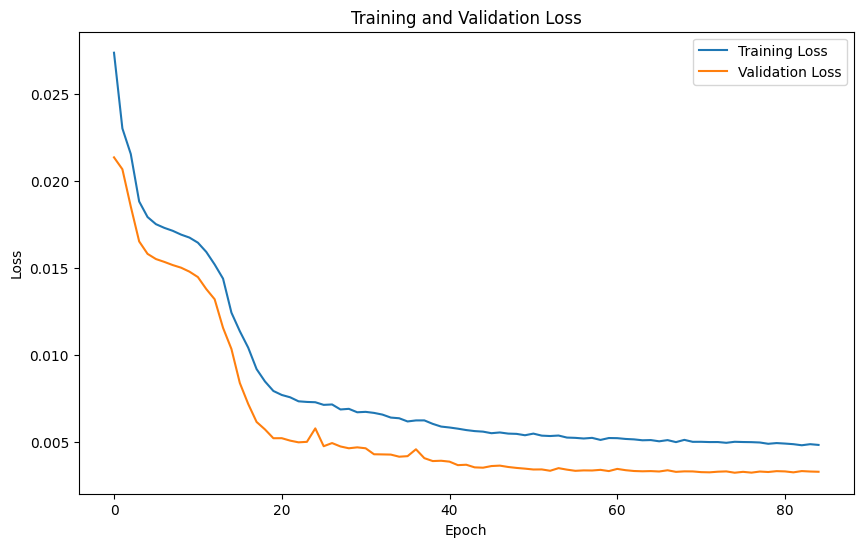

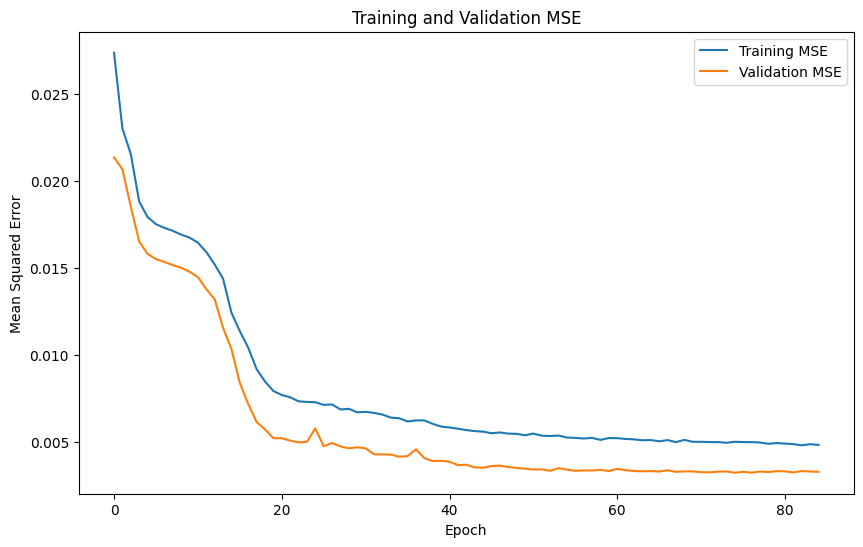

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation metrics (e.g., mean_squared_error)
plt.figure(figsize=(10, 6))
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation MSE')
plt.legend()
plt.show()

In [18]:
x_test, y = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)

print("x test shape: ", x_test.shape)
print("y shape: ", y.shape)
print("y pred shape: ", y_pred.shape)

Input shape:  (32, 31, 8, 1)
GCN input shape:  (8, 32, 31, 1)
GCN output shape:  (8, 32, 31, 64)
LSTM input shape:  (256, 31, 64)
LSTM output shape:  (256, 256)
Attention output shape:  (32, 8, 256)
Dense output:  (256, 1)
Output shape:  (8, 32, 1)
30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/stepInput shape:  (None, 31, 8, 1)
GCN input shape:  (8, None, 31, 1)
GCN output shape:  (8, None, 31, 64)
LSTM input shape:  (None, 31, 64)
LSTM output shape:  (None, 256)
Attention output shape:  (None, 8, 256)
Dense output:  (None, 1)
Output shape:  (8, None, 1)
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
x test shape:  (1146, 31, 8, 1)
y shape:  (1146, 1, 8)
y pred shape:  (1146, 1, 8)


In [19]:
def evaluate_all(y_true, y_pred):
    y_test_flat = y_true.reshape(-1, y_true.shape[-1]) 
    y_pred_flat = y_pred.reshape(-1, y_pred.shape[-1])
    
    r2 = r2_score(y_test_flat, y_pred_flat)
    mse = mean_squared_error(y_test_flat, y_pred_flat)
    rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
    mae = mean_absolute_error(y_test_flat, y_pred_flat)
    
    print(f"R²: {r2 * 100:.4f}%")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

evaluate_all(y, y_pred) 

R²: 95.7265%
MSE: 0.0031
RMSE: 0.0556
MAE: 0.0282


In [20]:
def evaluate_all_by_target_features(y_true, y_pred):
    stations = ['Noi Bai', 'Lang Son', 'Lao Cai', 
               'Vinh', 'Phu Bai', 'Quy Nhon',
               'TPHCM', 'Ca Mau']
    y_true_flat = y_true.reshape(-1, y_true.shape[-1]) 
    y_pred_flat = y_pred.reshape(-1, y_pred.shape[-1])

    for i in range(y_true_flat.shape[1]):
        y_true_feature = y_true_flat[:, i]
        y_pred_feature = y_pred_flat[:, i]
        
        r2 = r2_score(y_true_feature, y_pred_feature)
        mse = mean_squared_error(y_true_feature, y_pred_feature)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true_feature, y_pred_feature)
        
        print(f"Feature {stations[i]}:")
        print(f"  R²: {r2 * 100:.4f}%")
        print(f"  MSE: {mse:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print("-" * 30)

evaluate_all_by_target_features(y, y_pred)

Feature Noi Bai:
  R²: 97.2383%
  MSE: 0.0036
  RMSE: 0.0602
  MAE: 0.0317
------------------------------
Feature Lang Son:
  R²: 96.7190%
  MSE: 0.0043
  RMSE: 0.0659
  MAE: 0.0317
------------------------------
Feature Lao Cai:
  R²: 97.4655%
  MSE: 0.0031
  RMSE: 0.0558
  MAE: 0.0292
------------------------------
Feature Vinh:
  R²: 98.2517%
  MSE: 0.0021
  RMSE: 0.0462
  MAE: 0.0263
------------------------------
Feature Phu Bai:
  R²: 98.1191%
  MSE: 0.0026
  RMSE: 0.0511
  MAE: 0.0283
------------------------------
Feature Quy Nhon:
  R²: 98.0866%
  MSE: 0.0012
  RMSE: 0.0348
  MAE: 0.0197
------------------------------
Feature TPHCM:
  R²: 89.7630%
  MSE: 0.0038
  RMSE: 0.0620
  MAE: 0.0302
------------------------------
Feature Ca Mau:
  R²: 90.1691%
  MSE: 0.0039
  RMSE: 0.0622
  MAE: 0.0288
------------------------------


In [21]:
y_true_reshaped = y.reshape(-1, 8)
y_pred_reshaped = y_pred.reshape(-1, 8)

# Inverse transform
y_true_original = scaler.inverse_transform(y_true_reshaped)
y_pred_original = scaler.inverse_transform(y_pred_reshaped)

# Reshape về dạng ban đầu nếu cần
y_true_original = y_true_original.reshape(y.shape)
y_pred_original = y_pred_original.reshape(y_pred.shape)

print(y_true_original)

[[[33.54257 30.72112 30.53303 ... 33.65574 31.56987 30.49784]]

 [[34.49373 30.81134 27.54032 ... 34.23684 32.5501  30.9673 ]]

 [[35.48773 31.9078  26.27413 ... 33.35907 32.5654  30.61254]]

 ...

 [[32.5807  28.57104 34.73537 ... 33.65421 28.54503 27.45316]]

 [[29.5834  29.12919 28.73618 ... 30.5621  30.53303 29.03744]]

 [[32.5501  29.2393  31.1126  ... 31.05145 29.53903 27.1366 ]]]


In [22]:
def evaluate_all_by_station_original(y_true_original, y_pred_original):
    stations = ['Noi Bai', 'Lang Son', 'Lao Cai', 
               'Vinh', 'Phu Bai', 'Quy Nhon',
               'TPHCM', 'Ca Mau']
    
    y_true_flat = y_true_original.reshape(-1, y_true_original.shape[-1]) 
    y_pred_flat = y_pred_original.reshape(-1, y_pred_original.shape[-1])

    for i in range(y_true_flat.shape[1]):
        y_true_feature = y_true_flat[:, i]
        y_pred_feature = y_pred_flat[:, i]
        
        r2 = r2_score(y_true_feature, y_pred_feature)
        mse = mean_squared_error(y_true_feature, y_pred_feature)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true_feature, y_pred_feature)
        
        print(f"Station {stations[i]} (Original scale):") 
        print(f"  R²: {r2 * 100:.4f}%")
        print(f"  MSE: {mse:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print("-" * 30)

# Sử dụng
evaluate_all_by_station_original(y_true_original, y_pred_original)

Station Noi Bai (Original scale):
  R²: 97.2383%
  MSE: 0.9954
  RMSE: 0.9977
  MAE: 0.5251
------------------------------
Station Lang Son (Original scale):
  R²: 96.7190%
  MSE: 1.4039
  RMSE: 1.1849
  MAE: 0.5706
------------------------------
Station Lao Cai (Original scale):
  R²: 97.4655%
  MSE: 0.9062
  RMSE: 0.9520
  MAE: 0.4979
------------------------------
Station Vinh (Original scale):
  R²: 98.2517%
  MSE: 0.6242
  RMSE: 0.7900
  MAE: 0.4502
------------------------------
Station Phu Bai (Original scale):
  R²: 98.1191%
  MSE: 0.5523
  RMSE: 0.7432
  MAE: 0.4118
------------------------------
Station Quy Nhon (Original scale):
  R²: 98.0866%
  MSE: 0.2226
  RMSE: 0.4718
  MAE: 0.2677
------------------------------
Station TPHCM (Original scale):
  R²: 89.7630%
  MSE: 0.3290
  RMSE: 0.5736
  MAE: 0.2794
------------------------------
Station Ca Mau (Original scale):
  R²: 90.1691%
  MSE: 0.3086
  RMSE: 0.5555
  MAE: 0.2573
------------------------------
